<a href="https://colab.research.google.com/github/resfy/Allure.id/blob/main/Recomendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Preparation

In [1]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install kaggle

#Import Dataset From Kaggle

In [7]:
#upload kaggle json that already downloaded from kaggle.com
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"resfyresf","key":"1e6be933bf2899c887833c5f0eb261c4"}'}

In [8]:
#make new dir 'kaggle' and move 'kaggle.json' file to there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
#download amazon_top_50_bestselling_books
!kaggle datasets download -d saurav9786/amazon-product-reviews

 85% 93.0M/109M [00:00<00:00, 86.2MB/s]
100% 109M/109M [00:01<00:00, 113MB/s]  


In [10]:
!ls

amazon-product-reviews.zip  kaggle.json  sample_data


In [11]:
#unzip the dataset
zip_ref = zipfile.ZipFile('amazon-product-reviews.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [12]:
#read dataset as dataframe
df=pd.read_csv('/content/files/ratings_Electronics (1).csv',names=['userId', 'productId','Rating','timestamp'])

In [13]:
df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [15]:
#Check NA Value
df.isnull().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

In [16]:
#drop timestamp column because we don't use it for further processing
df.drop('timestamp', axis = 1, inplace = True)

In [17]:
len(df)

7824482

In [18]:
#Taking subset of the dataset. Because the data is too big.
df=df.iloc[:500000,0:]

#EDA

##Rating Distribution

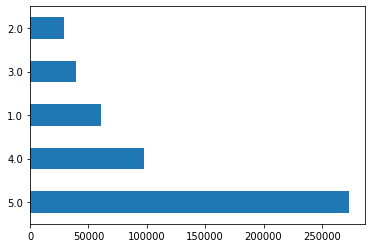

In [19]:
#Rating distribution
df['Rating'].value_counts().plot(kind='barh')

Most of user give '5' for ratings

In [20]:
#dataset info
df.describe()['Rating'].T

count    500000.000000
mean          3.987012
std           1.396382
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

##Rating per User

In [21]:
print("Dataset Shape :", df.shape[0])
print("Number of user in this dataset   :", len(np.unique(df.userId)))
print("Number of product in this dataset  :", len(np.unique(df.productId)))

Dataset Shape : 500000
Number of user in this dataset   : 404347
Number of product in this dataset  : 30667


In [44]:
#group datasets based on userId and count the number of times the user gives a rating
rated_products_per_user = df.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
rated_products_per_user.head(n=20)

userId
A5JLAU2ARJ0BO     296
A231WM2Z2JL0U3    247
A25HBO5V8S8SEA    155
AKT8TGIT6VVZ5      86
AT6CZDCP4TRGA      79
A11D1KHM7DVOQK     78
A6FIAB28IS79       78
A2AEZQ3DGBBLPR     77
A2B7BUH8834Y6M     74
ABH9D1TEOJ56E      64
A1MJMYLRTZ76ZX     58
A12DLJESJKM1OQ     57
A2R6RA8FRBS608     57
AT2J7H5TRZM8Z      57
AGHZXQL9F94T9      56
A203OCQQ12MAVT     56
A2BGZ52M908MJY     54
A1RPTVW5VEOSI      53
A7Y6AVS576M03      52
A1JWSDDIH5Z7DV     50
Name: Rating, dtype: int64

In [23]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=df.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [25]:
new_df.head()

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


##Rating per Product

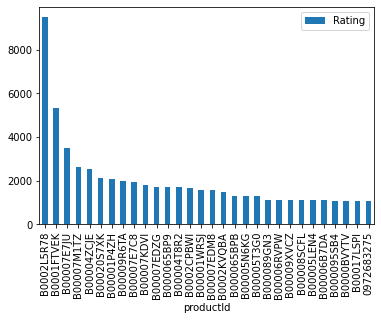

In [24]:
#get popular products
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [37]:
#import signature using this: from inspect import signature
!pip install recmetrics
import recmetrics

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


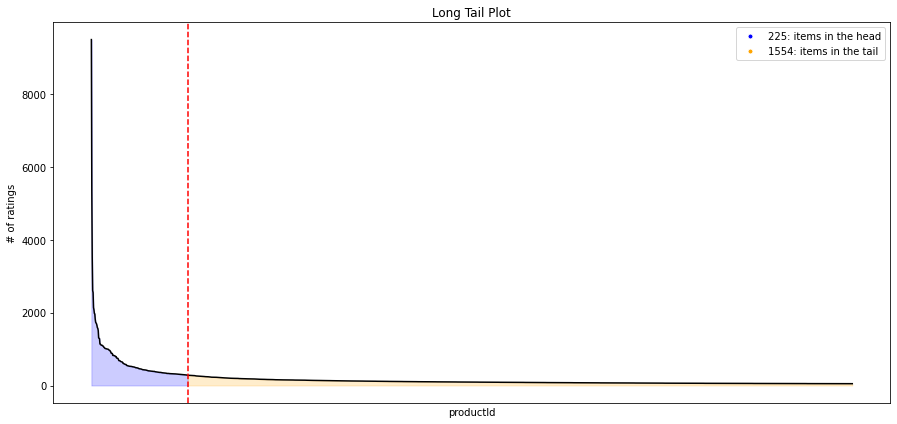

In [38]:
#Long Tail Plot
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(new_df, 
             item_id_column="productId", 
             interaction_type="ratings", 
             percentage=0.5,
             x_labels=False)

225 became popular product

#Recomendation System

Use collaborative filtering (item-item recomendation)

So, the sistem will give recommendation based on historical item ratings of like-minded people to predict how someone would rate an item.

In [45]:
!pip install surprise

In [46]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [47]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [48]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.1,random_state=10)

In [49]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
model = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [50]:
# run the trained model against the testset
test_pred = model.test(testset)

In [51]:
test_pred[:10]

[Prediction(uid='AXGIBK99SEXR4', iid='B00008XETL', r_ui=5.0, est=4.0652764546064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2C1VNPZUQPDQO', iid='B00009V39N', r_ui=3.0, est=4.0652764546064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2212O200XM77', iid='B00009R6GE', r_ui=5.0, est=4.0652764546064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AVXX8XO7SYV4M', iid='B00007EDZG', r_ui=5.0, est=4.0652764546064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1T11Z6RL0197A', iid='B00007E7JU', r_ui=5.0, est=4.0652764546064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2HFFIC5X7HTTQ', iid='B0000AKA90', r_ui=5.0, est=4.0652764546064, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1J1J3V1RHVGOJ', iid='B000

In [52]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3448


1.3448209129126354

based on RMSE evaluation, model prediction not yet optimal

In [53]:
testpred = pd.DataFrame(test_pred)
testpred = testpred.drop(labels='details', axis=1)
testpred.columns = ['UserId', 'ProductId', 'Actual', 'Pred']

In [54]:
testpred.head(n=100)

,UserId,ProductId,Actual,Pred
0,AXGIBK99SEXR4,B00008XETL,5.0,4.065276
1,A2C1VNPZUQPDQO,B00009V39N,3.0,4.065276
2,A2212O200XM77,B00009R6GE,5.0,4.065276
3,AVXX8XO7SYV4M,B00007EDZG,5.0,4.065276
4,A1T11Z6RL0197A,B00007E7JU,5.0,4.065276
...,...,...,...,...
95,A1P784U5U653MA,B000165GJI,5.0,4.065276
96,A12S9NMMSVITGR,B00007M1TZ,5.0,4.065276
97,A2H4AV1XG1MR4I,B0000C73CQ,5.0,4.065276
98,A1NMKKY7KYY46P,B00009QOS3,5.0,4.065276


#MAPK

In [58]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp37-none-any.whl size=7845 sha256=2fea69197e77120b2b53a776a4a4d17d7a64ee2e26e722c91a83d383ab3e560a
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [59]:
import ml_metrics as metrics

In [67]:
print(testpred['Actual'].values.tolist())
print(testpred['Pred'].values.tolist())


[5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 5.0, 5.0, 5.0, 5.0, 2.0, 4.0, 3.0, 2.0, 1.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 4.0, 5.0, 2.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 1.0, 5.0, 4.0, 5.0, 1.0, 1.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 1.0, 4.0, 5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 1.0, 5.0, 4.0, 1.0, 5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 1.0, 4.0, 5.0, 5.0, 5.0, 1.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 2.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 4.0, 2.0, 1.0, 5.0, 4.0, 1.0, 1.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 1.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 3.0, 3.0, 5.0, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 3.0, 5.0, 5.0, 5.0, 2.0, 5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0,

In [69]:
metrics.apk(testpred['Actual'].values.tolist(),testpred['Pred'].values.tolist())

0.0

#Save Model

In [39]:
## SAVING TRAINED MODEL
from surprise import dump
import os
model_filename = "./model.pickle"
print (">> Starting dump")
# Dump algorithm and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=model)
print (">> Dump done")
print(model_filename)

>> Starting dump
>> Dump done
./model.pickle


#Inferencing

Input: potongan data dari amazon review dataset.Use UserID and ProductID data. Then, predict user rating for the product and predict recomended product for user

In [40]:
## LOAD SAVED MODEL
def load_model(model_filename):
    from surprise import dump
    import os
    file_name = os.path.expanduser(model_filename)
    _, loaded_model = dump.load(file_name)
    return loaded_model

##GET RECOMMENDED PRODUCT FOR A USER
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [41]:
model_filename = "./model.pickle"
loaded_model = load_model(model_filename)

In [42]:
# make recommendations for all members in the test data
recomended_product = []

# run the trained model against the testset
test_pred = model.test(testset)

testpred = pd.DataFrame(test_pred)
testpred = testpred.drop(labels='details', axis=1)

#make a pivot table
pivot = testpred.pivot_table(index='uid', columns='iid', values='est').fillna(0)

#get 5 recommended product
for user in testpred['uid']:
    pred_item = get_users_predictions(user, 5, pivot)
    recomended_product.append(pred_item)
        
testpred['pred_item'] = recomended_product

In [43]:
testpred

,uid,iid,r_ui,est,pred_item
0,AXGIBK99SEXR4,B00008XETL,5.0,4.065276,"[B00008XETL, 0972683275, B0000C8VF9, B0000CD7K..."
1,A2C1VNPZUQPDQO,B00009V39N,3.0,4.065276,"[B00009V39N, 0972683275, B0000C8WLU, B0000CD7K..."
2,A2212O200XM77,B00009R6GE,5.0,4.065276,"[B00009R6GE, 0972683275, B0000C8WLU, B0000CD7K..."
3,AVXX8XO7SYV4M,B00007EDZG,5.0,4.065276,"[B00007EDZG, 0972683275, B0000C8VF9, B0000CD7K..."
4,A1T11Z6RL0197A,B00007E7JU,5.0,4.065276,"[B00007E7JU, 0972683275, B0000CDZ82, B0000CD7K..."
...,...,...,...,...,...
31486,A3AWIGEES5DLUZ,B0002KVQBA,5.0,4.065276,"[B0002KVQBA, 0972683275, B0000BZOGJ, B0000CD0B..."
31487,A31TMKWXQPZC1P,B00000JI4F,5.0,4.065276,"[B00000JI4F, 0972683275, B0000C8VF9, B0000CD7K..."
31488,AFHSZO56SOFKL,B00006B8BS,5.0,4.419118,"[B0001Y7UAI, B00006B8BS, 0972683275, B0000C8VF..."
31489,A3CH96BKZA87G8,B000067RT6,5.0,4.065276,"[B000067RT6, 0972683275, B0000CDZ82, B0000CD7K..."
